In [1]:
import os

# Set Dask temporary directory to a location with more space
# os.environ['DASK_TEMPORARY_DIRECTORY'] = "/Volumes/WD_BLACK/tmp"
# !export TMPDIR=/Volumes/WD_BLACK/tmp

import config
import os
import datetime
import random
import pandas as pd
import dask
import dask.dataframe as dd
from dask.diagnostics import ProgressBar

import numpy as np
import math
import geopandas as gpd
from shapely.geometry import Polygon
import scienceplots
import matplotlib.pyplot as plt
plt.style.use(['science'])

DATASET = '/Volumes/WD_BLACK/dataset/xian'
N = 1200
M = 600

In [2]:
def unix_to_datetime(timestamp: str) -> datetime:
    """ Convert Unix timestamp to datetime object
    >>> dt = unix_to_datetime('1538402919')
    >>> print(dt.strftime('%Y/%m/%d %H:%M:%S'))
    2018/10/01 22:08:39
    """
    return datetime.datetime.fromtimestamp(int(timestamp))


def get_filepaths(root_dir=DATASET, prefix='chengdu', suffix='.csv'):
    """ Get filepaths for files in the dataset directory """
    return [os.path.join(root_dir, file)
            for file in os.listdir(root_dir)
            if file.startswith(prefix) and file.endswith(suffix)]


def apply_expand(row):
    """ Process each row of the DataFrame """
    wid, oid = row['wid'], row['oid']
    points = row['traj'][1:-1].split(',')
    data = [{'wid': wid,
             'oid': oid,
             'lon': float(lon),
             'lat': float(lat),
             'dt': unix_to_datetime(timestamp)}
            for lon, lat, timestamp in (
        point.strip().split(' ') for point in points
    )]
    return pd.DataFrame(data)


def map_expand(partition):
    """ Process each partition of the DataFrame """
    return pd.concat([apply_expand(row) for index, row in partition.iterrows()]).drop_duplicates()

# Selection

## Workers

In [3]:
filepaths = get_filepaths(prefix='xian')
filepaths

['/Volumes/WD_BLACK/dataset/xian/xianshi_1001_1015.csv',
 '/Volumes/WD_BLACK/dataset/xian/xianshi_1015_1031.csv',
 '/Volumes/WD_BLACK/dataset/xian/xianshi_1101_1105.csv',
 '/Volumes/WD_BLACK/dataset/xian/xianshi_1115_1130.csv']

In [4]:
ddf_origin = dd.read_csv(filepaths, header=None, names=['oid', 'wid', 'traj'])
ddf_origin.head()

,oid,wid,traj
0,afab91fa68cb417c2f663924a0ba1ff9,44e01f89da70b70ec056827e6ba9c182,"[108.99553 34.27859 1539041301, 108.99552 34.2..."
1,e64d2f94bdf113be9fa1f3c43cbf71c0,fef0b56123153c8aad5e9ca5060877a3,"[108.9665 34.20515 1539014039, 108.9665 34.205..."
2,b585964500b816946634a5e3be0e6f5f,1e17801ec0b3edae76436143c70def94,"[108.99345 34.24538 1539014318, 108.99345 34.2..."
3,16509a95383718095fc2e84fcc755d8f,34404b0e12ee6593705c46d4bc4103db,"[108.9219 34.23344 1539023233, 108.92238 34.23..."
4,f97f2449867b98fa7af5952c31a09349,620a8ac6cd32a2ca49001f7eda91bd3f,"[108.94667 34.20517 1539037157, 108.94667 34.2..."


In [5]:
meta = pd.DataFrame({'wid': pd.Series(dtype='object'),
                     'oid': pd.Series(dtype='object'),
                     'lon': pd.Series(dtype='float64'),
                     'lat': pd.Series(dtype='float64'),
                     'dt': pd.Series(dtype='datetime64[ns]')})

output_expanded = os.path.join(DATASET, 'expanded')
if not os.path.exists(output_expanded) or len(os.listdir(output_expanded)) == 0:
    with ProgressBar():
        ddf_origin.map_partitions(map_expand, meta=meta).to_parquet(output_expanded)

ddf_expanded = dd.read_parquet(get_filepaths(output_expanded, 'part', '.parquet'))
ddf_expanded.head()

,wid,oid,lon,lat,dt
0,44e01f89da70b70ec056827e6ba9c182,afab91fa68cb417c2f663924a0ba1ff9,108.99553,34.27859,2018-10-09 07:28:21
1,44e01f89da70b70ec056827e6ba9c182,afab91fa68cb417c2f663924a0ba1ff9,108.99552,34.27822,2018-10-09 07:28:24
2,44e01f89da70b70ec056827e6ba9c182,afab91fa68cb417c2f663924a0ba1ff9,108.99552,34.27786,2018-10-09 07:28:27
3,44e01f89da70b70ec056827e6ba9c182,afab91fa68cb417c2f663924a0ba1ff9,108.99552,34.27748,2018-10-09 07:28:30
4,44e01f89da70b70ec056827e6ba9c182,afab91fa68cb417c2f663924a0ba1ff9,108.99551,34.27708,2018-10-09 07:28:33


In [6]:
output_worker = os.path.join(DATASET, 'wid_peek.csv')

if not os.path.exists(output_worker):
    with ProgressBar():
        ddf_expanded['date'] = ddf_expanded['dt'].dt.date
        ddf_expanded[['wid', 'date']].drop_duplicates().groupby(by='wid')['date'].nunique(
        ).reset_index().to_csv(output_worker, single_file=True, index=False)

wid_peek = pd.read_csv(output_worker).sort_values('date', ascending=False)
workers = wid_peek[wid_peek['date'] >= 59]
workers

,wid,date
20867,3d5f7c3fc68b3b4718b4c52baae3fb78,62
24421,47d30eb632ae72843f691030b4b3e66d,62
1410,0448872d519d7ce614aad783f46f7d01,62
11567,21deb76de0fa215e913989c982230675,62
38965,71bc3d3ea337ad8814a6e1d2d8ffe6a1,62
...,...,...
39248,7294c8114db5b2b1bb0080c0303fd01a,59
66190,c2f053738635b6b04b70323150507989,59
82552,f3c615ef7b2d20895d614c7989d99b46,59
38959,71ba2eb0c7359114106ba15e7289cf50,59


In [7]:
output_selected = os.path.join(DATASET, 'selected')

if not os.path.exists(output_selected) or len(os.listdir(output_selected)) == 0:
    with ProgressBar():
        os.makedirs(output_selected, exist_ok=True)
        ddf_expanded[ddf_expanded['wid'].isin(workers['wid'])].to_parquet(output_selected)

selected_files = get_filepaths(output_selected, 'part', '.parquet')
ddf_selected = dd.read_parquet(selected_files)
ddf_selected.head()

,wid,oid,lon,lat,dt
0,620a8ac6cd32a2ca49001f7eda91bd3f,f97f2449867b98fa7af5952c31a09349,108.94667,34.20517,2018-10-09 06:19:17
1,620a8ac6cd32a2ca49001f7eda91bd3f,f97f2449867b98fa7af5952c31a09349,108.94667,34.20553,2018-10-09 06:19:20
2,620a8ac6cd32a2ca49001f7eda91bd3f,f97f2449867b98fa7af5952c31a09349,108.94669,34.20596,2018-10-09 06:19:23
3,620a8ac6cd32a2ca49001f7eda91bd3f,f97f2449867b98fa7af5952c31a09349,108.94670,34.20643,2018-10-09 06:19:26
4,620a8ac6cd32a2ca49001f7eda91bd3f,f97f2449867b98fa7af5952c31a09349,108.94670,34.20693,2018-10-09 06:19:29


## Tasks

In [8]:
# with ProgressBar():
#     min_lat, max_lat, min_lon, max_lon = dd.compute(
#         ddf_expanded['lat'].min(),
#         ddf_expanded['lat'].max(),
#         ddf_expanded['lon'].min(),
#         ddf_expanded['lon'].max(),
#     )
min_lat, max_lat, min_lon, max_lon = (34.20495, 34.2786, 108.92186, 109.00883)

(601, 5)


<Axes: >

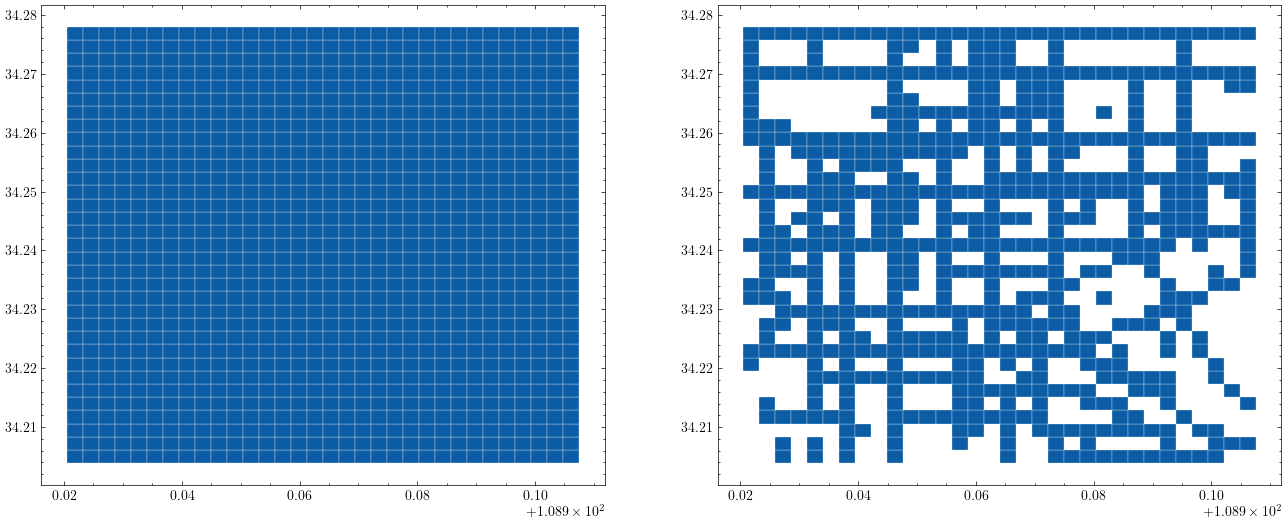

In [9]:
# min_lat, max_lat, min_lon, max_lon = dd.compute(
#     ddf_expanded['lat'].min(),
#     ddf_expanded['lat'].max(),
#     ddf_expanded['lon'].min(),
#     ddf_expanded['lon'].max(),
# )
# min_lat, max_lat, min_lon, max_lon

grid_size = 250
earth_radius = 6371004

# min_lat, max_lat, min_lon, max_lon = (30.65283, 30.72649, 104.04211, 104.12907)
delta_lat = grid_size * 360 / (2 * math.pi * earth_radius)
delta_lon = grid_size * 360 / (2 * math.pi * earth_radius * math.cos((min_lat + max_lat) * math.pi / 360))
ddf_selected['lon_index'] = ((ddf_selected['lon'] - (min_lon - delta_lon / 2)) / delta_lon).astype('int')
ddf_selected['lat_index'] = ((ddf_selected['lat'] - (min_lat - delta_lat / 2)) / delta_lat).astype('int')

output_grid = os.path.join(DATASET, 'grid.shp')

# Grids
grid_data_list = []
num_lon_grids = int((max_lon - min_lon) / delta_lon) + 1
num_lat_grids = int((max_lat - min_lat) / delta_lat) + 1
for i in range(num_lon_grids):
    center_lon = i * delta_lon + min_lon
    for j in range(num_lat_grids):
        center_lat = j * delta_lat + min_lat
        grid_polygon = Polygon([
            (center_lon - delta_lon / 2, center_lat - delta_lat / 2),
            (center_lon + delta_lon / 2, center_lat - delta_lat / 2),
            (center_lon + delta_lon / 2, center_lat + delta_lat / 2),
            (center_lon - delta_lon / 2, center_lat + delta_lat / 2)
        ])
        grid_data_list.append({
            'lon_index': i,
            'lat_index': j,
            'lon_center': center_lon,
            'lat_center': center_lat,
            'geometry': grid_polygon
        })
grid_data = gpd.GeoDataFrame(grid_data_list, columns=['lon_index', 'lat_index', 'lon_center', 'lat_center', 'geometry'])
grid_data.set_geometry('geometry', inplace=True)
grid_data.to_file(output_grid)
gdf_grid = gpd.read_file(output_grid)

# Tasks
output_task = os.path.join(DATASET, 'oid_peek.csv')

if not os.path.exists(output_task):
    with ProgressBar():
        oid_peek = ddf_selected[['lon_index', 'lat_index', 'oid']].groupby(by=['lon_index', 'lat_index'])['oid'].count().reset_index().compute()
        oid_peek.sort_values(by='oid', ascending=False).to_csv(output_task, index=False)

oid_peek = pd.read_csv(output_task).sort_values('oid', ascending=False)
tasks = oid_peek[oid_peek['oid'] >= 6e4].copy()
tasks['lat_lon'] = tasks['lat_index'].astype(str) + '-' + tasks['lon_index'].astype(str)


gdf_grid_filtered = gdf_grid.merge(tasks[['lon_index', 'lat_index']],
                                   on=['lon_index', 'lat_index'],
                                   how='inner')
print(gdf_grid_filtered.shape)
fig, axes = plt.subplots(1, 2, figsize=(16, 7.5))
gdf_grid.plot(ax=axes[0], edgecolor='white', linewidth=0.2)
gdf_grid_filtered.plot(ax=axes[1], edgecolor='white', linewidth=0.2)

In [10]:
tasks

,lon_index,lat_index,oid,lat_lon
0,9,8,1553582,8-9
1,9,16,1215463,16-9
2,9,29,1109227,29-9
3,6,11,976782,11-6
4,4,11,956093,11-4
...,...,...,...,...
601,12,6,61427,6-12
602,18,28,61253,28-18
603,2,0,60316,0-2
604,7,9,60160,9-7


In [11]:
tasks[tasks['lat_lon'] == '8-9']

,lon_index,lat_index,oid,lat_lon
0,9,8,1553582,8-9


# Attribute

## Data cleaned

In [12]:
output_final = os.path.join(DATASET, 'final')
ddf_selected['lat_lon'] = ddf_selected['lat_index'].astype(str) + '-' + ddf_selected['lon_index'].astype(str)

if not os.path.exists(output_final) or len(os.listdir(output_final)) == 0:
    with ProgressBar():
        os.makedirs(output_final, exist_ok=True)
        ddf_selected[ddf_selected['lat_lon'].isin(tasks['lat_lon'])].to_parquet(output_final)

final_files = get_filepaths(output_final, 'part', '.parquet')
ddf_final = dd.read_parquet(final_files)
ddf_final['date'] = ddf_final['dt'].dt.date.astype(str)
ddf_final.head()

,wid,oid,lon,lat,dt,lon_index,lat_index,lat_lon,date
0,620a8ac6cd32a2ca49001f7eda91bd3f,f97f2449867b98fa7af5952c31a09349,108.94667,34.20517,2018-10-09 06:19:17,9,0,0-9,2018-10-09
1,620a8ac6cd32a2ca49001f7eda91bd3f,f97f2449867b98fa7af5952c31a09349,108.94667,34.20553,2018-10-09 06:19:20,9,0,0-9,2018-10-09
2,620a8ac6cd32a2ca49001f7eda91bd3f,f97f2449867b98fa7af5952c31a09349,108.94669,34.20596,2018-10-09 06:19:23,9,0,0-9,2018-10-09
3,620a8ac6cd32a2ca49001f7eda91bd3f,f97f2449867b98fa7af5952c31a09349,108.94670,34.20643,2018-10-09 06:19:26,9,1,1-9,2018-10-09
4,620a8ac6cd32a2ca49001f7eda91bd3f,f97f2449867b98fa7af5952c31a09349,108.94670,34.20693,2018-10-09 06:19:29,9,1,1-9,2018-10-09


In [13]:
output_grouped_csv = os.path.join(DATASET, 'grouped.csv')
meta = pd.DataFrame({'duration': pd.Series(dtype='float64')})


def calculate_stay_duration(group):
    group = group.sort_values('dt')
    time_diff = group['dt'].diff().dt.total_seconds()
    duration = time_diff[time_diff <= 15].sum()
    return pd.Series({'duration': duration})


if not os.path.exists(output_grouped_csv):
    with ProgressBar():
        grouped = ddf_final.groupby(['wid', 'lat_lon', 'date'])
        grouped.apply(calculate_stay_duration, meta=meta).reset_index(
        ).to_csv(output_grouped_csv, single_file=True, index=False)

df_grouped = pd.read_csv(output_grouped_csv)
df_grouped.head()

[########################################] | 100% Completed | 100m 28s


,wid,lat_lon,date,duration
0,00475183ecd9b8c177e97254e9824414,11-27,2018-11-14,48.0
1,00475183ecd9b8c177e97254e9824414,13-15,2018-11-01,19.0
2,00475183ecd9b8c177e97254e9824414,16-31,2018-11-04,31.0
3,00475183ecd9b8c177e97254e9824414,32-1,2018-11-14,73.0
4,00475183ecd9b8c177e97254e9824414,5-20,2018-10-16,21.0


In [14]:
df_grouped.describe()

,duration
count,2.082768e+06
mean,5.962296e+01
std,7.566414e+01
min,0.000000e+00
25%,1.900000e+01
50%,3.600000e+01
75%,7.200000e+01
max,2.122300e+04


In [ ]:
ddf_final.head()

In [15]:
with ProgressBar():
    df = ddf_final[ddf_final['wid'] == '620a8ac6cd32a2ca49001f7eda91bd3f'].compute()

[########################################] | 100% Completed | 89.26 s


<Axes: >

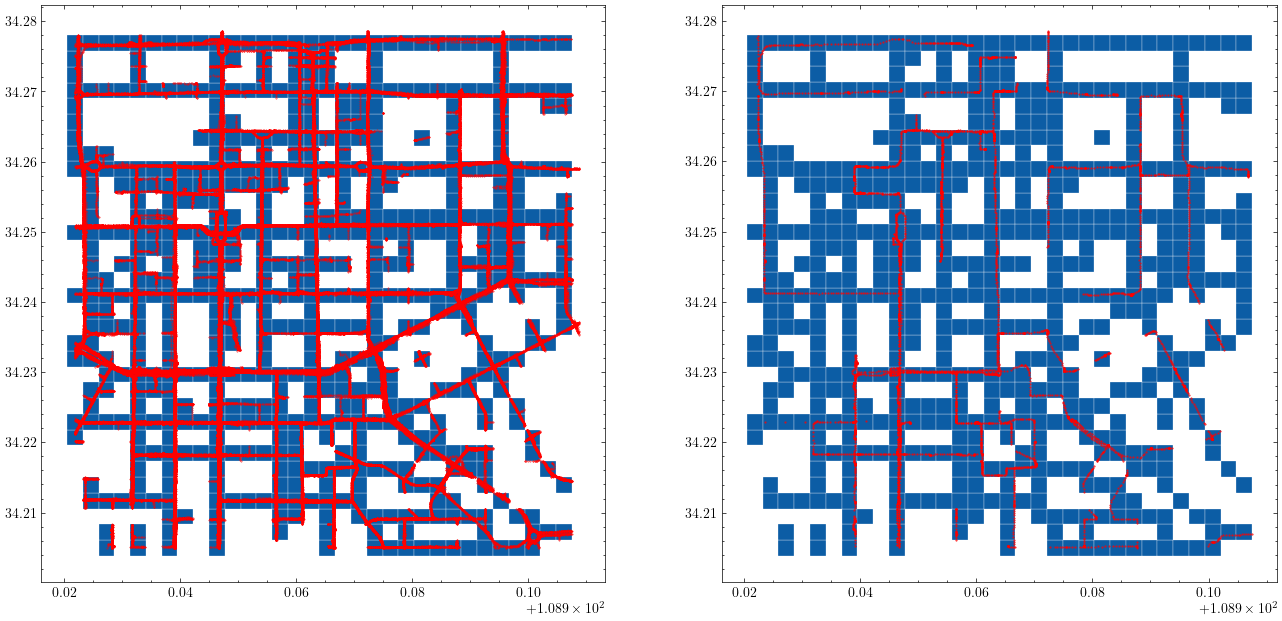

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7.5))
gdf_grid_filtered.plot(ax=axes[0], edgecolor='white', linewidth=0.2)
gdf_grid_filtered.plot(ax=axes[1], edgecolor='white', linewidth=0.2)

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['lon'], df['lat']), crs="EPSG:4326")
gdf.plot(ax=axes[0], color="red", markersize=0.1)

df2 = df[df['date'] == '2018-10-01'].copy()
gdf2 = gpd.GeoDataFrame(df2, geometry=gpd.points_from_xy(df2['lon'], df2['lat']), crs="EPSG:4326")
gdf2.plot(ax=axes[1], color="red", markersize=0.2)

In [17]:
# Step 1: Calculate the number of days each driver visits each lat_lon
visits_per_day = df_grouped.groupby(['wid', 'lat_lon'])['date'].nunique().reset_index()
visits_per_day = visits_per_day.rename(columns={'date': 'days_visited'})
visits_per_day

,wid,lat_lon,days_visited
0,00475183ecd9b8c177e97254e9824414,0-16,11
1,00475183ecd9b8c177e97254e9824414,0-19,8
2,00475183ecd9b8c177e97254e9824414,0-2,7
3,00475183ecd9b8c177e97254e9824414,0-20,12
4,00475183ecd9b8c177e97254e9824414,0-21,13
...,...,...,...
157233,ff723293684978da93010dd602b8aacf,9-28,12
157234,ff723293684978da93010dd602b8aacf,9-4,18
157235,ff723293684978da93010dd602b8aacf,9-6,14
157236,ff723293684978da93010dd602b8aacf,9-7,4


In [18]:
visits_per_day[visits_per_day['wid'] == '620a8ac6cd32a2ca49001f7eda91bd3f']['days_visited'].max()

53

In [19]:
# Step 2: Calculate the number of days with duration limits for each driver at each lat_lon
filtered_df = df_grouped[df_grouped['duration'] > 15]
days_with_long_duration = filtered_df.groupby(['wid', 'lat_lon'])['date'].nunique().reset_index()
days_with_long_duration = days_with_long_duration.rename(columns={'date': 'days_with_long_duration'})
days_with_long_duration

# Step 3: Merge the datasets and calculate the ratio
merged_data = pd.merge(days_with_long_duration, visits_per_day, on=['wid', 'lat_lon'], how='right')
merged_data['duration_ratio'] = 1.0 * merged_data['days_with_long_duration'] / merged_data['days_visited']
merged_data.fillna(0, inplace=True)

merged_data

,wid,lat_lon,days_with_long_duration,days_visited,duration_ratio
0,00475183ecd9b8c177e97254e9824414,0-16,4.0,11,0.363636
1,00475183ecd9b8c177e97254e9824414,0-19,5.0,8,0.625000
2,00475183ecd9b8c177e97254e9824414,0-2,6.0,7,0.857143
3,00475183ecd9b8c177e97254e9824414,0-20,9.0,12,0.750000
4,00475183ecd9b8c177e97254e9824414,0-21,10.0,13,0.769231
...,...,...,...,...,...
157233,ff723293684978da93010dd602b8aacf,9-28,12.0,12,1.000000
157234,ff723293684978da93010dd602b8aacf,9-4,15.0,18,0.833333
157235,ff723293684978da93010dd602b8aacf,9-6,14.0,14,1.000000
157236,ff723293684978da93010dd602b8aacf,9-7,4.0,4,1.000000


In [20]:
# all_combinations = pd.MultiIndex.from_product([df_grouped['wid'].unique(), df_grouped['lat_lon'].unique()], names=['wid', 'lat_lon']).to_frame(index=False)
arrive_pro = df_grouped[['wid', 'lat_lon', 'date']].groupby(['wid', 'lat_lon']).nunique().reset_index()
arrive_pro['date'] /= 62
# arrive_pro = pd.merge(all_combinations, arrive_pro, on=['wid', 'lat_lon'], how='left').fillna(0)
arrive_pro = arrive_pro.rename(columns={'date': 'ArrivePro'})
arrive_pro

,wid,lat_lon,ArrivePro
0,00475183ecd9b8c177e97254e9824414,0-16,0.177419
1,00475183ecd9b8c177e97254e9824414,0-19,0.129032
2,00475183ecd9b8c177e97254e9824414,0-2,0.112903
3,00475183ecd9b8c177e97254e9824414,0-20,0.193548
4,00475183ecd9b8c177e97254e9824414,0-21,0.209677
...,...,...,...
157233,ff723293684978da93010dd602b8aacf,9-28,0.193548
157234,ff723293684978da93010dd602b8aacf,9-4,0.290323
157235,ff723293684978da93010dd602b8aacf,9-6,0.225806
157236,ff723293684978da93010dd602b8aacf,9-7,0.064516


In [21]:
combined = pd.merge(arrive_pro, merged_data, on=['wid', 'lat_lon'], how='right')
combined = pd.merge(df_grouped[['wid']].drop_duplicates(ignore_index=True).reset_index(), combined, on=['wid'], how='right')
combined['index'] = combined['index'] + 1
combined.drop(columns=['days_with_long_duration', 'days_visited'], inplace=True)
combined = combined.rename(columns={'duration_ratio': 'qPro'})
np.random.seed(0)

combined['lat_lon'] = combined['lat_lon'].apply(lambda s: s.replace(',', '-'))
combined['taskFare'] = np.random.randint(10, 20, size=(combined.shape[0], 1))
combined['travelFare'] = np.random.randint(10, 25, size=(combined.shape[0], 1))

combined['Fare'] = combined['taskFare'] + combined['travelFare']
combined[['index', 'lat_lon', 'taskFare', 'ArrivePro', 'qPro', 'Fare']].round(
    {'qPro': 2, 'ArrivePro': 2}).to_csv('everyCarPro.txt', index=False, header=None)

combined = pd.merge(combined.groupby(by=['wid'])['qPro'].mean().reset_index().rename(columns={'qPro': 'qPro_avg'}), combined, on=['wid'], how='right')
combined['Pro'] = combined['ArrivePro'] * combined['qPro_avg']

combined[['index', 'qPro_avg']].drop_duplicates().round(
    {'qPro_avg': 2}).to_csv('carList.txt', index=False, header=None)

combined[['index', 'qPro_avg']].drop_duplicates().round(
    {'qPro_avg': 2}).to_csv('everyCarQualific.txt', index=False, header=None)

combined

,wid,qPro_avg,index,lat_lon,ArrivePro,qPro,taskFare,travelFare,Fare,Pro
0,00475183ecd9b8c177e97254e9824414,0.878418,1,0-16,0.177419,0.363636,15,13,28,0.155848
1,00475183ecd9b8c177e97254e9824414,0.878418,1,0-19,0.129032,0.625000,10,22,32,0.113344
2,00475183ecd9b8c177e97254e9824414,0.878418,1,0-2,0.112903,0.857143,13,21,34,0.099176
3,00475183ecd9b8c177e97254e9824414,0.878418,1,0-20,0.193548,0.750000,13,16,29,0.170016
4,00475183ecd9b8c177e97254e9824414,0.878418,1,0-21,0.209677,0.769231,17,10,27,0.184185
...,...,...,...,...,...,...,...,...,...,...
157233,ff723293684978da93010dd602b8aacf,0.833225,261,9-28,0.193548,1.000000,15,11,26,0.161269
157234,ff723293684978da93010dd602b8aacf,0.833225,261,9-4,0.290323,0.833333,17,11,28,0.241904
157235,ff723293684978da93010dd602b8aacf,0.833225,261,9-6,0.225806,1.000000,19,16,35,0.188148
157236,ff723293684978da93010dd602b8aacf,0.833225,261,9-7,0.064516,1.000000,13,16,29,0.053756


In [22]:
output = combined[['index', 'lat_lon', 'taskFare', 'Pro', 'qPro_avg', 'Fare', 'ArrivePro']]
output.round({'Pro': 2, 'qPro_avg': 2, 'ArrivePro': 2, }).to_csv('CarInformation.txt', index=False, header=None)
output

,index,lat_lon,taskFare,Pro,qPro_avg,Fare,ArrivePro
0,1,0-16,15,0.155848,0.878418,28,0.177419
1,1,0-19,10,0.113344,0.878418,32,0.129032
2,1,0-2,13,0.099176,0.878418,34,0.112903
3,1,0-20,13,0.170016,0.878418,29,0.193548
4,1,0-21,17,0.184185,0.878418,27,0.209677
...,...,...,...,...,...,...,...
157233,261,9-28,15,0.161269,0.833225,26,0.193548
157234,261,9-4,17,0.241904,0.833225,28,0.290323
157235,261,9-6,19,0.188148,0.833225,35,0.225806
157236,261,9-7,13,0.053756,0.833225,29,0.064516


In [23]:
output['10'] = 10
output[['lat_lon', '10']].to_csv('POI.txt', index=False, header=None)

In [24]:
output

,index,lat_lon,taskFare,Pro,qPro_avg,Fare,ArrivePro,10
0,1,0-16,15,0.155848,0.878418,28,0.177419,10
1,1,0-19,10,0.113344,0.878418,32,0.129032,10
2,1,0-2,13,0.099176,0.878418,34,0.112903,10
3,1,0-20,13,0.170016,0.878418,29,0.193548,10
4,1,0-21,17,0.184185,0.878418,27,0.209677,10
...,...,...,...,...,...,...,...,...
157233,261,9-28,15,0.161269,0.833225,26,0.193548,10
157234,261,9-4,17,0.241904,0.833225,28,0.290323,10
157235,261,9-6,19,0.188148,0.833225,35,0.225806,10
157236,261,9-7,13,0.053756,0.833225,29,0.064516,10


In [25]:
with open('carList_code', 'w') as fout:
    fout.write(str(output['index'].drop_duplicates().to_list()))